<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [26]:
from tqdm.auto import tqdm%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Modeling
Importing modules and data from prevoius step


In [27]:
## Fit Models with Training Data Set
import pandas as pd
import numpy as np

import joblib
import pickle

from timeit import default_timer as timer
from datetime import datetime, date
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fast')
import seaborn as sns

In [28]:
 from timeit import default_timer as timer
from datetime import datetime, date
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [29]:
#Load data and scaler model

X_train_scaled = pd.read_csv("../data/X_train_scaled.csv").to_numpy()
y_train = pd.read_csv("../data/y_train.csv").to_numpy().ravel()
X_train_over_scaled = pd.read_csv("../data/X_train_over_scaled.csv").to_numpy()
y_train_over = pd.read_csv("../data/y_train_over.csv").to_numpy().ravel()
X_test_scaled = pd.read_csv("../data/X_test_scaled.csv").to_numpy()
y_test = pd.read_csv("../data/y_test.csv").to_numpy().ravel()
feature_list = pd.read_csv("../data/feature_list.csv")
feature_list = pd.Index(list(feature_list["0"]))

scaler = joblib.load("../models/scaler.pkl")

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [30]:
train_df = pd.DataFrame(X_train_scaled, columns = feature_list)
train_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.00000,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.00277,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.00554,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.00831,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.01108,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


In [31]:
train_over_df = pd.DataFrame(X_train_over_scaled, columns = feature_list)
train_over_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.506925,0.623494,0.434489,0.500169,0.407407,0.333333,0.271112,0.470238,0.484009,0.323529,0.268862,0.476722,0.333333,0.441860,0.365231
1,0.493075,0.394578,0.452365,0.606347,0.541063,0.227273,0.448219,0.541667,0.558635,0.235294,0.471308,0.491343,0.416667,0.581395,0.450152
2,0.686981,0.533133,0.611729,0.447333,0.628019,0.378788,0.170690,0.452381,0.432836,0.397059,0.151460,0.471335,0.583333,0.426357,0.394919
3,0.484765,0.512048,0.529758,0.613774,0.433172,0.409091,0.184017,0.505952,0.652452,0.308824,0.193415,0.406310,0.500000,0.465116,0.325324
4,0.396122,0.584337,0.523872,0.562627,0.421900,0.530303,0.051512,0.642857,0.479744,0.411765,0.084787,0.721431,0.666667,0.279070,0.421983


In [32]:
test_df = pd.DataFrame(X_test_scaled, columns = feature_list)
test_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.00000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834
1,0.00277,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827
2,0.00554,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348
3,0.00831,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110
4,0.01108,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377


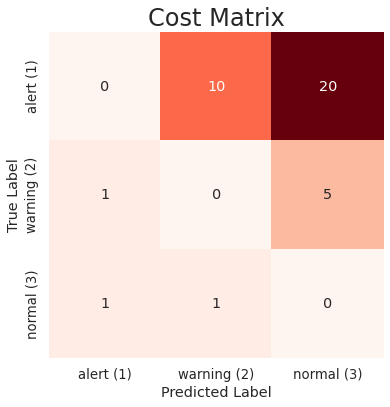

In [33]:
cost_matrix = [[0,10,20],[1,0,5],[1,1,0]]
categories = ['alert (1)','warning (2)','normal (3)']

fig = plt.figure(figsize=(6,6))
sns.set(font_scale=1.2)
ax = sns.heatmap(cost_matrix, annot=cost_matrix, fmt='', cmap='Reds', cbar=False, xticklabels=categories)
ax.set_yticklabels(categories, rotation=90, va="center")
sns.set(font_scale=1.4)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
sns.set(font_scale=2)
ax.set_title('Cost Matrix')
plt.savefig("../figures/Cost_Matrix.png") 

## Fit Models with Training Data Set

Let's build some useful functions

In [34]:
def my_cost_function(y_test, y_pred):
    cost_matrix = [[0,10,20],[1,0,5],[1,1,0]]
    conf_matrix = confusion_matrix(y_test, y_pred)
    loss = -np.sum(conf_matrix*cost_matrix)
    return loss

my_score = make_scorer(my_cost_function, greater_is_better=False)

In [35]:
def try_model(model, X_train, y_train, X_test, y_test):
    """ Fits a model on the selected data with the default parameters 
    ex. usage 
        summary = try_model(KNeighborsClassifier(),X_train, y_train)"""
    # statements
    print('Trying Model :'+ str(model))
    start = timer()
    model.fit(X_train, y_train)
    middle = timer()
    test_score = model.score(X_test, y_test)
    #cv_score = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    end = timer()
    train_score = model.score(X_train, y_train) 
    
    
    #my_test_score = cross_val_score(model, X_test, y_test, cv=5, scoring=my_score)
    #print("|  Mean Cost: %0.2f (+/- %0.2f)" % (my_test_score.mean(), my_test_score.std() * 2))
    
    # calculate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cost = my_cost_function(y_test, y_pred)
    
    print('|  Train Score: ' + str(round(train_score,3)))
    print('|  Test Score: ' + str(round(test_score,3)))
    
    train_elapsed = round(middle - start,3)
    test_elapsed = round(end - middle,3)

    summary = {'model_name': str(model),
               'training time [s]': train_elapsed,
               'test time [s]': test_elapsed,
               'test accuracy': test_score,
               'cost':cost,
               'train accuracy': train_score,
              'confusion matrix': cm,
              'trained_model':model}
    #print(summary)
    
    return summary

In [41]:
def plot_multiclass_confusion_matrix(y_test, y_pred, categories):
    """Plots the confusion matrix given the data and the lables."""
    
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    stats_text = "\n\nAccuracy={:0.2f}%".format(100*np.trace(cm) / float(np.sum(cm)))
    
    box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

    fig = plt.figure(figsize=(6,6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=box_labels, fmt='', cmap='Reds', xticklabels=categories, yticklabels=categories)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(stats_text)
    
    return fig, ax
 

In [42]:
models_summary = pd.DataFrame()
models_summary_over = pd.DataFrame()



### Dummy Classifier


In [43]:
strategies = ['most_frequent', 'stratified', 'prior', 'uniform']

for s in tqdm(strategies) :
    res = try_model(DummyClassifier(strategy=s), X_train_scaled, y_train, X_test_scaled, y_test)
    models_summary = models_summary.append(res, ignore_index=True)
    res_over = try_model(DummyClassifier(strategy=s), X_train_over_scaled, y_train_over, X_test_scaled, y_test)
    models_summary_over = models_summary_over.append(res_over, ignore_index=True)


Trying Model :DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
|  Train Score: 0.515
|  Test Score: 0.761
Trying Model :DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
|  Train Score: 0.333
|  Test Score: 0.065
Trying Model :DummyClassifier(constant=None, random_state=None, strategy='stratified')
|  Train Score: 0.382
|  Test Score: 0.453
Trying Model :DummyClassifier(constant=None, random_state=None, strategy='stratified')
|  Train Score: 0.335
|  Test Score: 0.33
Trying Model :DummyClassifier(constant=None, random_state=None, strategy='prior')
|  Train Score: 0.515
|  Test Score: 0.761
Trying Model :DummyClassifier(constant=None, random_state=None, strategy='prior')
|  Train Score: 0.333
|  Test Score: 0.065
Trying Model :DummyClassifier(constant=None, random_state=None, strategy='uniform')
|  Train Score: 0.341
|  Test Score: 0.332
Trying Model :DummyClassifier(constant=None, random_state=None, strategy='uniform')
|  Train Score

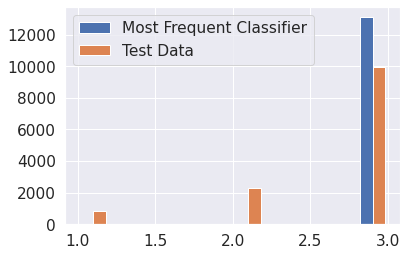

In [44]:
clf_dummy = DummyClassifier(strategy='most_frequent').fit(X_train_scaled, y_train)
y_dummy = clf_dummy.predict(X_test_scaled)
sns.set(font_scale=1.4)
plt.hist([y_dummy, y_test])
plt.legend(['Most Frequent Classifier', 'Test Data'])

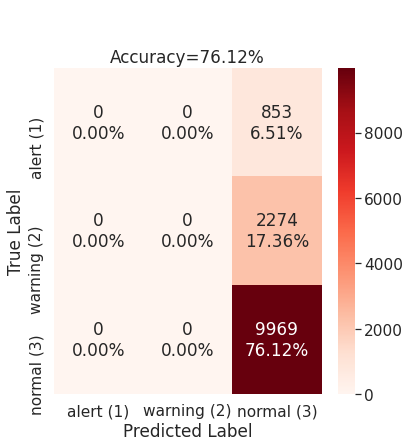

In [45]:
_ = plot_multiclass_confusion_matrix(y_test, clf_dummy.predict(X_test_scaled),['alert (1)','warning (2)','normal (3)'])
plt.savefig("../figures/most_frequent_classifier.png") 

In [47]:
models_summary

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
0,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-28430.0,"DummyClassifier(constant=None, random_state=No...",0.761225,0.001,0.515293,"DummyClassifier(constant=None, random_state=No...",0.001
1,"[[211, 203, 439], [583, 522, 1169], [2347, 247...",-22059.0,"DummyClassifier(constant=None, random_state=No...",0.452734,0.003,0.381707,"DummyClassifier(constant=None, random_state=No...",0.002
2,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-28430.0,"DummyClassifier(constant=None, random_state=No...",0.761225,0.001,0.515293,"DummyClassifier(constant=None, random_state=No...",0.001
3,"[[284, 295, 274], [720, 790, 764], [3370, 3326...",-19666.0,"DummyClassifier(constant=None, random_state=No...",0.331628,0.001,0.340943,"DummyClassifier(constant=None, random_state=No...",0.001


In [48]:
models_summary_over

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
0,"[[853, 0, 0], [2274, 0, 0], [9969, 0, 0]]",-12243.0,"DummyClassifier(constant=None, random_state=No...",0.065134,0.001,0.333333,"DummyClassifier(constant=None, random_state=No...",0.002
1,"[[300, 273, 280], [745, 760, 769], [3444, 3258...",-19622.0,"DummyClassifier(constant=None, random_state=No...",0.330254,0.003,0.334964,"DummyClassifier(constant=None, random_state=No...",0.001
2,"[[853, 0, 0], [2274, 0, 0], [9969, 0, 0]]",-12243.0,"DummyClassifier(constant=None, random_state=No...",0.065134,0.001,0.333333,"DummyClassifier(constant=None, random_state=No...",0.002
3,"[[286, 275, 292], [728, 796, 750], [3293, 3234...",-19595.0,"DummyClassifier(constant=None, random_state=No...",0.322465,0.001,0.337033,"DummyClassifier(constant=None, random_state=No...",0.001


--> The Dummy Classifier: Most Frequent has 0.761 Accuracy!

### Test stock models (Default Parameters)
- KNeighborsClassifier
- SVC - Linear and RBF
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier




In [49]:
models_to_try = [KNeighborsClassifier(),
                 KNeighborsClassifier(n_neighbors=3),
                 DecisionTreeClassifier(),
                 DecisionTreeClassifier(criterion='gini',max_depth=3),
                 RandomForestClassifier(),
                 RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                 SVC(),
                 SVC(kernel="linear", C=0.025),
                 AdaBoostClassifier(),
                 GradientBoostingClassifier()
                ]
short_names = ['most_frequent', 'stratified', 'prior', 'uniform'] + ['KNN()',
                 'KNN(3)',
                 'Tree()',
                 'Tree(gini,d=3)',
                 'RandomForest()',
                 'RF(d=5, n=10, f=1)',
                 'SVC()',
                 'SVC("linear", C=0.025)',
                 'Ada()',
                 'Gradient()'
                ]

In [95]:
# # Commented for speed of execution - results are saved in pickles
# for m in tqdm(models_to_try) :
#     res = try_model(m, X_train_scaled, y_train, X_test_scaled, y_test)
#     models_summary = models_summary.append(res, ignore_index=True)
#     res_over = try_model(m, X_train_over_scaled, y_train_over, X_test_scaled, y_test)
#     models_summary_over = models_summary_over.append(res_over, ignore_index=True)

In [55]:
# pkl_filename = "../models/pickle_models_summary_"+str(date.today())+".pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(models_summary, file)
    
# pkl_filename = "../models/pickle_models_summary_over_"+str(date.today())+".pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(models_summary_over, file)

Console Output
```
Trying Model :KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
|  Train Score: 0.848
|  Test Score: 0.802
Trying Model :KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
|  Train Score: 0.895
|  Test Score: 0.754
Trying Model :KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
|  Train Score: 0.875
|  Test Score: 0.79
Trying Model :KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
|  Train Score: 0.937
|  Test Score: 0.753
Trying Model :DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
|  Train Score: 1.0
|  Test Score: 0.765
Trying Model :DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
|  Train Score: 1.0
|  Test Score: 0.767
Trying Model :DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
|  Train Score: 0.758
|  Test Score: 0.776
Trying Model :DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
|  Train Score: 0.748
|  Test Score: 0.766
Trying Model :RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
|  Train Score: 1.0
|  Test Score: 0.832
Trying Model :RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
|  Train Score: 1.0
|  Test Score: 0.831
Trying Model :RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
|  Train Score: 0.778
|  Test Score: 0.82
Trying Model :RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
|  Train Score: 0.782
|  Test Score: 0.804
Trying Model :SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
|  Train Score: 0.81
|  Test Score: 0.839
Trying Model :SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
|  Train Score: 0.808
|  Test Score: 0.794
Trying Model :SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
|  Train Score: 0.782
|  Test Score: 0.826
Trying Model :SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
|  Train Score: 0.779
|  Test Score: 0.802
Trying Model :AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
|  Train Score: 0.782
|  Test Score: 0.834
Trying Model :AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
|  Train Score: 0.761
|  Test Score: 0.8
Trying Model :GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
|  Train Score: 0.831
|  Test Score: 0.836
Trying Model :GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
|  Train Score: 0.832
|  Test Score: 0.809
```

In [56]:
pkl_filename = "../models/pickle_models_summary_2020-11-01.pkl"
with open(pkl_filename, 'rb') as file:
    models_summary = pickle.load(file)
    

pkl_filename = "../models/pickle_models_summary_over_2020-11-01.pkl"    
with open(pkl_filename, 'rb') as file:
    models_summary_over = pickle.load(file)

In [57]:
models_summary.sort_values(by=['test accuracy'], ascending=False).head()

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
10,"[[520, 294, 39], [88, 1224, 962], [10, 716, 92...",-9344.0,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.838958,5.430,0.810043,"SVC(C=1.0, break_ties=False, cache_size=200, c...",9.705
13,"[[576, 253, 24], [127, 1311, 836], [19, 886, 9...",-8222.0,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.836210,0.044,0.831419,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",17.600
12,"[[585, 227, 41], [210, 1050, 1014], [85, 598, ...",-9053.0,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.833919,0.149,0.782027,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",1.327
8,"[[554, 268, 31], [115, 1259, 900], [23, 868, 9...",-8806.0,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.831628,0.184,1.000000,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",3.765
11,"[[519, 275, 59], [110, 947, 1217], [27, 589, 9...",-10741.0,"SVC(C=0.025, break_ties=False, cache_size=200,...",0.826130,2.489,0.781785,"SVC(C=0.025, break_ties=False, cache_size=200,...",7.298


In [58]:
models_summary_over.sort_values(by=['test accuracy'], ascending=False).head()

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
8,"[[563, 264, 26], [115, 1410, 749], [18, 1041, ...",-8079.0,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.831017,0.189,1.000000,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",5.272
13,"[[582, 266, 5], [126, 1700, 448], [24, 1636, 8...",-6786.0,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.808720,0.044,0.831719,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",25.736
9,"[[548, 297, 8], [140, 1508, 626], [31, 1460, 8...",-7891.0,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.804368,0.011,0.782147,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.114
11,"[[527, 310, 16], [116, 1610, 548], [25, 1580, ...",-7881.0,"SVC(C=0.025, break_ties=False, cache_size=200,...",0.801848,4.548,0.779074,"SVC(C=0.025, break_ties=False, cache_size=200,...",17.874
12,"[[560, 270, 23], [189, 1423, 662], [66, 1412, ...",-8137.0,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.799786,0.127,0.761358,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",1.877


In [59]:
models_summary.sort_values(by=['cost'], ascending=False).head()

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
13,"[[576, 253, 24], [127, 1311, 836], [19, 886, 9...",-8222.0,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.836210,0.044,0.831419,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",17.600
8,"[[554, 268, 31], [115, 1259, 900], [23, 868, 9...",-8806.0,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.831628,0.184,1.000000,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",3.765
7,"[[524, 310, 19], [179, 1410, 685], [50, 1694, ...",-8828.0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.775733,0.001,0.758422,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.058
12,"[[585, 227, 41], [210, 1050, 1014], [85, 598, ...",-9053.0,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.833919,0.149,0.782027,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",1.327
4,"[[568, 239, 46], [235, 1116, 923], [112, 1040,...",-9312.0,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.801848,4.454,0.848093,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.146


<ipython-input-66-0b905a41fc83>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(labels, rotation=0)
<ipython-input-66-0b905a41fc83>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(labels, rotation=0)


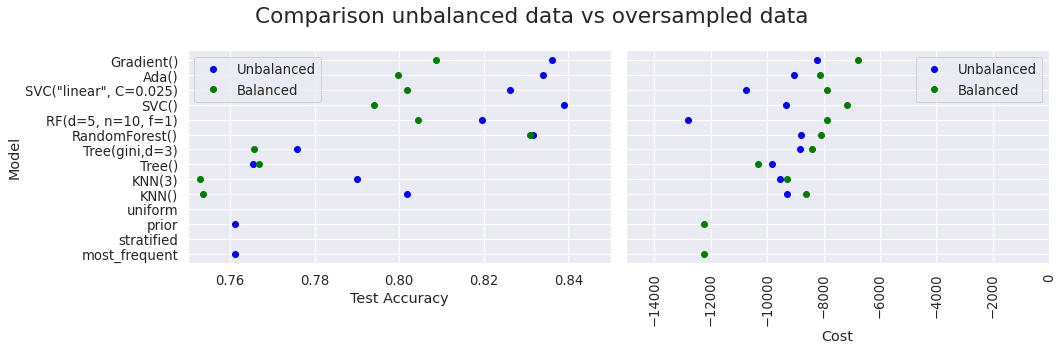

In [66]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
sns.set(font_scale=1.5)
fig.suptitle('Comparison unbalanced data vs oversampled data')
sns.set(font_scale=1.2)
_ = ax[0].plot(models_summary['test accuracy'],models_summary['model_name'],'o',linestyle='None',color='blue')
_ = ax[0].plot(models_summary_over['test accuracy'],models_summary_over['model_name'],'o',linestyle='None',color='green')
_ = ax[0].legend(['Unbalanced', 'Balanced'])
labels = short_names
_ = ax[0].set_yticklabels(labels, rotation=0)
_ = ax[0].set_xlim([0.75,0.85])
#_ = ax[0].set_title('Test Accuracy')
_ = ax[0].set_xlabel('Test Accuracy')
_ = ax[0].set_ylabel('Model')

_ = ax[1].plot(models_summary['cost'],models_summary['model_name'],'o',linestyle='None',color='blue')
_ = ax[1].plot(models_summary_over['cost'],models_summary_over['model_name'],'o',linestyle='None',color='green')
_ = ax[1].legend(['Unbalanced', 'Balanced'])
labels = short_names
_ = ax[1].set_yticklabels(labels, rotation=0)
_ = plt.xticks(rotation=90)
_ = ax[1].set_xlim([-15000, 0])
#ax[1].set_title('Cost')
_ = ax[1].set_xlabel('Cost')
#ax[1].set_ylabel('Cost')

plt.tight_layout()
plt.savefig("../figures/Naive_model_comparison.png") 


In [69]:
models_summary_over[['model_name','cost','test accuracy']].sort_values(by=['cost'], ascending=False).head(2)

,model_name,cost,test accuracy
13,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",-6786.0,0.808720
10,"SVC(C=1.0, break_ties=False, cache_size=200, c...",-7158.0,0.793983


## Hyperparameters Tuning

Let's finetune the Gradient Bosting Classifier and Support Vector Classifiers (rbf kernel) with the balanced dataset as they are the top performers when considering Cost.


### GridSearchCV
We set up the code but it turns out to be too time consuming. We didn't complete this in favor of Bayesin Search Optimization 


In [32]:
# model_grid = [{'C' : np.logspace(-2, 5,num=8),
#                'kernel': ['rbf'],
#                'gamma' :  np.logspace(-2, 3,num=6)},
#               {'learning_rate':np.logspace(-2,0,num=6),
#                'n_estimators':np.arange(1,202,10),
#                'max_depth':np.linspace(1, 32, 32, endpoint=True),
#                'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
#                'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
#                'max_features':list(range(1,X_train_over_scaled.shape[1]))}]             
# models = [SVC(), GradientBoostingClassifier()]    
# hyper_tuning = pd.DataFrame()
# for model, param_grid in tqdm(zip(models, model_grid)):
#     print("Training model : " + str(model))
#     print("Start Time : "+ str(datetime.now()))
#     grid_cv = GridSearchCV(model,param_grid, cv=3, refit=True)
#     start = timer()
#     grid_cv.fit(X_train_over_scaled,y_train_over)
#     end = timer()
#     test_score = grid_cv.score(X_test_scaled, y_test)
#     y_pred = grid_cv.predict(X_test_scaled)
#     cm = confusion_matrix(y_test, y_pred)
#     cost = my_cost_function(y_test, y_pred)
#     print(str(round(end - start,3)) + ' seconds elapsed.')
#     print("|----Best Score:" + str(grid_cv.best_score_))
#     print("|----Best Parameters: " + str(grid_cv.best_params_))
#     hyper_tuning = hyper_tuning.append({'Training model': model,
#                         'grid_cv object': grid_cv,
#                         'Time':round(end - start,3),
#                         'Test Score':test_score,
#                         'Cost':cost,
#                         'Best Score':grid_cv.best_score_,
#                         'Confusion Matrix':cm,
#                         'Best Parameters': grid_cv.best_params_}, ignore_index=True)

### Bayesian Optiomization


Uncomment the code block below to run the bayesian search. 
For reference, the full search took approximately 7 hours on a laptop with the following specs:
```
Model: Lenovo x220
Kernel: x86_64 Linux 5.3.0-61-generic
OS: Mint 19.3 tricia
CPU: Intel Core i7-2620M @ 4x 3.4GHz
GPU: Mesa DRI Intel(R) HD Graphics 3000 (SNB GT2)
RAM: 6197MiB / 15896MiB
```
The results of the search are saved in the models folder as pickles


In [84]:
# # define search space 
# params_list = [{'learning_rate':Real(1e-2,1e+0,prior='log-uniform'),
#                'n_estimators':Integer(1,200,prior='uniform'),
#                'max_depth':Integer(1,20,prior='uniform'),
#                'min_samples_split':Real(0.1, 1.0, prior='uniform'),
#                'min_samples_leaf':Real(0.1, 0.5, prior='uniform'),
#                'max_features':Integer(1,X_train_scaled.shape[1], prior='uniform')},
#                {'C': Real(1e-2, 1e+5, prior='log-uniform'),
#                 'gamma': Real(1e-2, 1e+3, prior='log-uniform'),
#                 'kernel': Categorical(['rbf'])}]

# estimator_list = [GradientBoostingClassifier(),SVC()]

# # define the search
# for model, param_grid in tqdm(zip(estimator_list,params_list)):
#     print("Searching best parameters for "+ str(model))
#     print("Start Time : "+ str(datetime.now()))
#     search = BayesSearchCV(estimator=model,
#                          search_spaces=param_grid,
#                          n_jobs=-1,
#                          n_iter=50,
#                          n_points=1,
#                          random_state=0,
#                          cv=3,
#                          verbose=100,
#                          refit=True,
#                          return_train_score = True)
#     # perform bayesian optimization
#     print("Start Time : "+ str(datetime.now()))
#     search.fit(X_train_over_scaled, y_train_over)
#     print("End Time : "+ str(datetime.now()))
#     pkl_filename = "pickle_bayes_search_model_"+ str(datetime.now())  +".pkl"
#     pkl_path = "../models/"+pkl_filename
#     print(type(search))
#     with open(pkl_path, 'wb') as file:
#         pickle.dump(search, file)
#     print("|----Best Score:" + str(search.best_score_))
#     print("|----Best Parameters: " + str(search.best_params_))

Searching best parameters for GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Start Time : 2020-11-01 22:53:36.635687
Start Time : 2020-11-01 22:53:36.635785
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.8s finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0802s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]:

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1469s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished
End Time : 2020-11-01 23:21:14.303471
<class 'skopt.searchcv.BayesSearchCV'>
|----Best Score:0.8615683692346283
|----Best Parameters: OrderedDict([('learning_rate', 1.0), ('max_depth', 16), ('max_features', 15), ('min_samples_leaf', 0.1), ('min_samples_split', 0.1), ('n_estimators', 200)])
Searching best parameters for SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Start Time : 2020-11-01 23:21:14.352376
Start Time : 2020-11-01 23:21:14.352959


/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.0min finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: D

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_job

```
GradientBoostingClassifier()
Start Time : 2020-11-01 22:53:36.635687
End Time : 2020-11-01 23:21:14.303471
|----Best Score:0.8615683692346283
|----Best Parameters: OrderedDict([('learning_rate', 1.0), ('max_depth', 16), ('max_features', 15), ('min_samples_leaf', 0.1), ('min_samples_split', 0.1), ('n_estimators', 200)])



SVC()
Start Time : 2020-11-01 23:21:14.352376
End Time : 2020-11-02 02:35:55.203282
|----Best Score:0.903615213369705
|----Best Parameters: OrderedDict([('C', 8.329889141799534), ('gamma', 66.24267077888531), ('kernel', 'rbf')])
```

# Model Choice

In [88]:
pkl_list = ['pickle_bayes_search_model_2020-11-01 23:21:14.303596.pkl',
'pickle_bayes_search_model_2020-11-02 02:35:55.203397.pkl']


pickle_bayes_search_model_2020-11-01 23:21:14.303596.pkl
OrderedDict([('learning_rate', 1.0), ('max_depth', 16), ('max_features', 15), ('min_samples_leaf', 0.1), ('min_samples_split', 0.1), ('n_estimators', 200)])
Test Score :0.8017715332926084
Cost :-8021
pickle_bayes_search_model_2020-11-02 02:35:55.203397.pkl
OrderedDict([('C', 8.329889141799534), ('gamma', 66.24267077888531), ('kernel', 'rbf')])
Test Score :0.8159743433109347
Cost :-11489


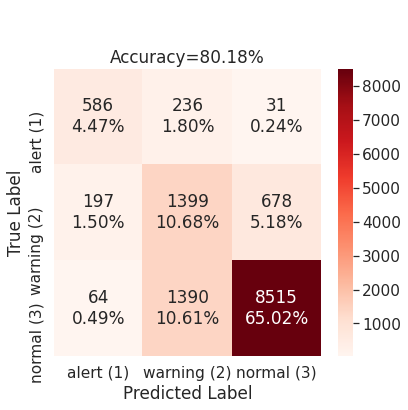

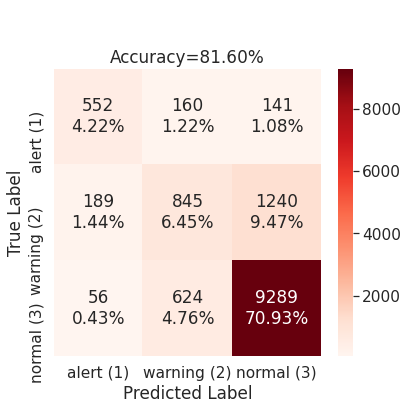

In [89]:
for pkl in pkl_list :
    # Load Model
    pkl_path = "../models/" + pkl
    loaded_model = pickle.load(open(pkl_path, 'rb'))
    
    # calculate
    test_score = loaded_model.score(X_test_scaled, y_test)
    y_pred = loaded_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    cost = my_cost_function(y_test, y_pred)
    
    # Print Summary
    #print(loaded_model)
    print(pkl)
    print(loaded_model.best_params_)
    print('Test Score :' + str(test_score))
    print('Cost :' + str(cost))
    #Plot Confusion Matrix
    _ = plot_multiclass_confusion_matrix(y_test, y_pred,['alert (1)','warning (2)','normal (3)'])
    plt.tight_layout()
    plt.savefig("../figures/"+pkl+'.png') 
    
   
    

The Gradient Boosting Classifier has the lowest miscalssification cost. 

```
GradientBoostingClassifier()
pickle_bayes_search_model_2020-11-01 23:21:14.303596.pkl
OrderedDict([('learning_rate', 1.0), ('max_depth', 16), ('max_features', 15), ('min_samples_leaf', 0.1), ('min_samples_split', 0.1), ('n_estimators', 200)])
Test Score :0.8017715332926084
Cost :-8021

SVC()
pickle_bayes_search_model_2020-11-02 02:35:55.203397.pkl
OrderedDict([('C', 8.329889141799534), ('gamma', 66.24267077888531), ('kernel', 'rbf')])
Test Score :0.8159743433109347
Cost :-11489
```

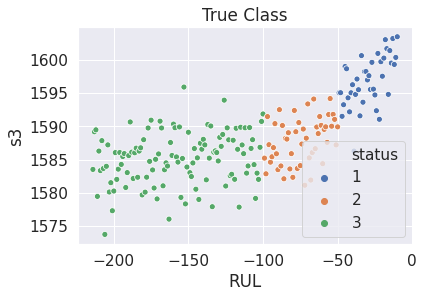

In [90]:
import random
#let's see it in action
# pick one engine trace from the test dataset
test_df = pd.read_csv('../data/test_op_regime2_FD001.csv')

# random_unit = random.choice(test_df['unit_number'].unique())
# print('Unit number : '+ str(random_unit)) 
random_unit = 76 #76 is a good example

test_df = test_df[test_df['unit_number']==random_unit]

#setting an arbitary boundary at 50 and 100 cycles for the binning\
first_boundary = -100
second_boundary = -50
test_df['status'] = pd.cut(test_df['RUL'],[-np.inf,first_boundary,second_boundary,0],labels=[3,2,1])

_ = sns.scatterplot('RUL','s3',data = test_df, hue='status')
_ = plt.title('True Class')
plt.savefig('../figures/SIMULATION_true_class.png')

In [91]:
cols_to_drop = ['dataset','unit_number', 
        'op_setting_1', 'op_setting_2', 'op_setting_3',
        's1', 's5', 's6', 's10', 's16', 's18', 's19',
        'op_regime','RUL']
predictor_col = ['status']

X_test = test_df.drop(cols_to_drop + predictor_col, axis=1).to_numpy()
X_test_scaled=scaler.transform(X_test)

best_model = pickle.load(open("../models/pickle_bayes_search_model_2020-10-18 20:03:06.122143.pkl", 'rb'))
y_pred = best_model.predict(X_test_scaled)
test_df['pred_status']=y_pred

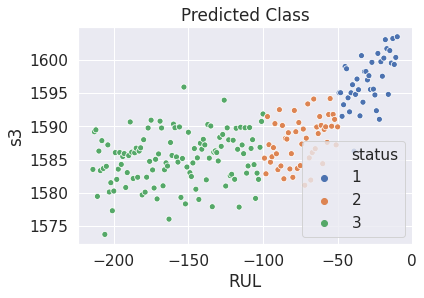

In [92]:
_ = sns.scatterplot('RUL','s3',data = test_df, hue='status')
_ = plt.title('Predicted Class')
plt.savefig('../figures/SIMULATION_predicted_class.png')

In [93]:
test_df['correct'] = test_df['pred_status'] == test_df['status']

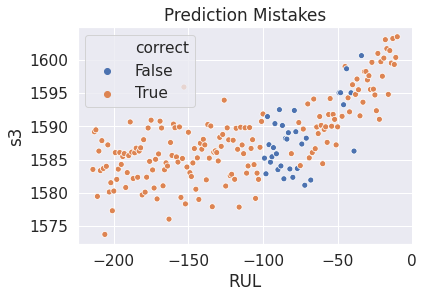

In [94]:
_ = sns.scatterplot('RUL','s3',data = test_df, hue='correct')
_ = plt.title('Prediction Mistakes')
plt.savefig('../figures/SIMULATION_classification_error.png')